In [1]:
#importing libraries

import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import nn
import torch.nn.functional as F
from torch import optim

In [2]:
#Using Cuda

def get_default_device():

  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_default_device()
device

device(type='cpu')

In [4]:
#defining plot function

from matplotlib import pyplot as plt
%matplotlib  inline

def showData(h,w, img, lbl):
  
  fig = plt.figure(figsize=(10,10))
  plt.axis('off')
  counter = 0
  for i in range(img.shape[0]):

      fig.add_subplot(w,h,counter+1)
      plt.imshow(img[i][0,:,:],'gray')
      plt.axis('off')
      title = str(lbl[i].item())
      plt.title(title)
      counter += 1

In [5]:
#defining DataLoader

class deviceDataLoader():

  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):

    for img, lbl in self.dl:
      yield to_device((img,lbl), self.device)

  def __len__(self):

    return len(self.dl)

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [7]:
#creating Dataset

train_transform = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ]
)

test_tranform = transforms.Compose(
    [
        transforms.ToTensor()

    ]
)

train_ds = MNIST(root = './data/', train=True, transform = train_transform, download=True)
test_ds = MNIST(root='./data/', train= False, transform= test_tranform, download= True)

train_ds, val_ds = random_split(train_ds, [0.85, 0.15])

In [9]:
#creating DataLoader

batch_size = 128
train_ld = DataLoader(train_ds, batch_size = batch_size)
val_ld = DataLoader(val_ds, batch_size = batch_size)
test_ld = DataLoader(test_ds, batch_size=batch_size)

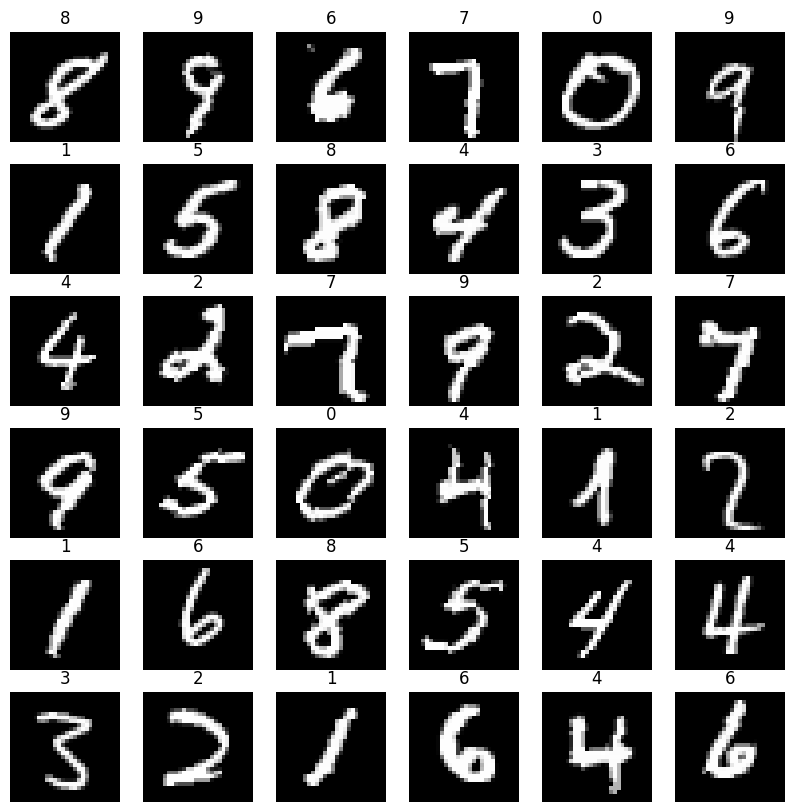

In [10]:
#plot random data

for img,lbl in train_ld:
  
  showData(6,6,img[:36], lbl[:36])
  break

In [12]:
train_ld = deviceDataLoader(train_ld, device)
val_ld = deviceDataLoader(val_ld, device)
test_ld = deviceDataLoader(test_ld, device)

In [13]:
#defining Model

class model(nn.Module):

    def __init__(self):
      super(model, self).__init__()
      self.cnn1 = nn.Conv2d(1, 4, 3, 1, 1)
      self.MxPl = nn.MaxPool2d(2,2)
      self.cnn2 = nn.Conv2d(4, 4, 3, 2, 2, 1)
      self.cnn3 = nn.Conv2d(4, 2, 5, 1, 3, 3)
      self.cnn4 = nn.Conv2d(4, 4, 3, 1, 2, 1)
      self.lnr1 = nn.Linear(10*8*8, 300)
      self.do1   = nn.Dropout(0.2)
      self.lnr2 = nn.Linear(300, 100)
      self.do2   = nn.Dropout(0.15)
      self.lnr3 = nn.Linear(100, 40)
      self.do3   = nn.Dropout(0.10)
      self.lnr4 = nn.Linear(40,10)


    def forward(self, img):
      img = self.cnn1(img)
      img = self.MxPl(img)
      res1 = self.cnn2(img)
      res2 = self.cnn3(img)
      res3 = self.cnn4(img)
      res3 = self.MxPl(res3)
      img = torch.cat((res1, res2, res3), 1)
      img = torch.relu(img)
      img = torch.reshape(img, (-1, 640))
      img = self.lnr1(img)
      img = self.do1(img)
      img = torch.relu(img)
      img = self.lnr2(img)
      img = self.do2(img)
      img = torch.relu(img)
      img = self.lnr3(img)
      img = self.do3(img)
      img = torch.relu(img)
      img = self.lnr4(img)
      return img

In [14]:
#creating Model

myModel = model()
to_device(myModel, device)

model(
  (cnn1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (MxPl): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (cnn3): Conv2d(4, 2, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3), dilation=(3, 3))
  (cnn4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (lnr1): Linear(in_features=640, out_features=300, bias=True)
  (do1): Dropout(p=0.2, inplace=False)
  (lnr2): Linear(in_features=300, out_features=100, bias=True)
  (do2): Dropout(p=0.15, inplace=False)
  (lnr3): Linear(in_features=100, out_features=40, bias=True)
  (do3): Dropout(p=0.1, inplace=False)
  (lnr4): Linear(in_features=40, out_features=10, bias=True)
)

In [15]:
#defining Train & Test Function

def trainOneEpoch(model, train_ld, val_ld, opt):

  numOfDataInTrain = batch_size * len(train_ld)
  numOfDataInEval = batch_size * len(val_ld)

  trainLoss = 0
  trainCorrect = 0
  model.train()
  for img, lbl in train_ld:

    opt.zero_grad()
    pred = model(img)
    loss = F.cross_entropy(pred, lbl)
    loss.backward()
    opt.step()
    trainLoss += loss.item()
    trainCorrect += torch.sum(torch.argmax(pred,dim=1)==lbl)

  evalLoss = 0
  evalCorrect = 0
  model.eval()
  with torch.no_grad():

    for img, lbl in val_ld:

      pred = model(img)
      loss = F.cross_entropy(pred, lbl)
      evalLoss += loss.item()
      evalCorrect += torch.sum(torch.argmax(pred,dim=1)==lbl)    

  return (trainLoss/len(train_ld), trainCorrect.item()/numOfDataInTrain*100, evalLoss/len(val_ld), evalCorrect.item()/numOfDataInEval*100)


def train(model, learningRate, epochs, train_ld, val_ld):
  modelInfo = list()

  for epoch in range(epochs):
    opt = optim.SGD(myModel.parameters(), lr = learningRate / (epoch/3+1) , momentum=0.9)
    modelInfo.append(trainOneEpoch(myModel, train_ld, val_ld, opt))
    print('epoch: {}'.format(epoch))
    print('trainig phase:    accuracy {:.2f}%, average loss {:.4f},'.format(modelInfo[-1][1], modelInfo[-1][0]))
    print('evaluation phase: accuracy {:.2f}%, average loss {:.4f}.\n'.format(modelInfo[-1][3], modelInfo[-1][2]))

  return modelInfo


def test(model, test_ld):

  print('test phase:')
  model.eval()
  loss = 0
  correct = 0
  counter = 0
  with torch.no_grad():

    for img, lbl in test_ld:

      pred = model(img)
      loss += F.cross_entropy(pred, lbl)

      correct += torch.sum((torch.argmax(pred,dim=1)==lbl))
      counter += pred.shape[0]

  loss /= counter
  accuracy = 100.0 * correct / counter
  print('average loss is:{:.4f} , and percentage of correct prediction:{:.2f}%'.format(loss.item(), accuracy))

In [16]:
def plot_acc(acc_ls:list):

  train_acc = [x[1] for x in acc_ls]
  eval_acc = [x[3] for x in acc_ls ]

  plt.title('model accuracy')

  plt.plot(train_acc, '-bx')
  plt.plot(eval_acc , '-rx')
  
  plt.xticks(range(len(train_acc)))
  plt.ylim(0,100)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend(['train','eval'])
  plt.show()

epoch: 0
trainig phase:    accuracy 38.96%, average loss 1.7262,
evaluation phase: accuracy 88.11%, average loss 0.3881.

epoch: 1
trainig phase:    accuracy 89.14%, average loss 0.3521,
evaluation phase: accuracy 92.50%, average loss 0.2174.

epoch: 2
trainig phase:    accuracy 93.10%, average loss 0.2238,
evaluation phase: accuracy 94.33%, average loss 0.1476.

epoch: 3
trainig phase:    accuracy 94.56%, average loss 0.1760,
evaluation phase: accuracy 95.20%, average loss 0.1221.

epoch: 4
trainig phase:    accuracy 95.30%, average loss 0.1495,
evaluation phase: accuracy 95.62%, average loss 0.1075.

epoch: 5
trainig phase:    accuracy 95.89%, average loss 0.1335,
evaluation phase: accuracy 95.77%, average loss 0.1081.

epoch: 6
trainig phase:    accuracy 96.30%, average loss 0.1197,
evaluation phase: accuracy 96.14%, average loss 0.0937.

epoch: 7
trainig phase:    accuracy 96.46%, average loss 0.1123,
evaluation phase: accuracy 96.36%, average loss 0.0872.

epoch: 8
trainig phase: 

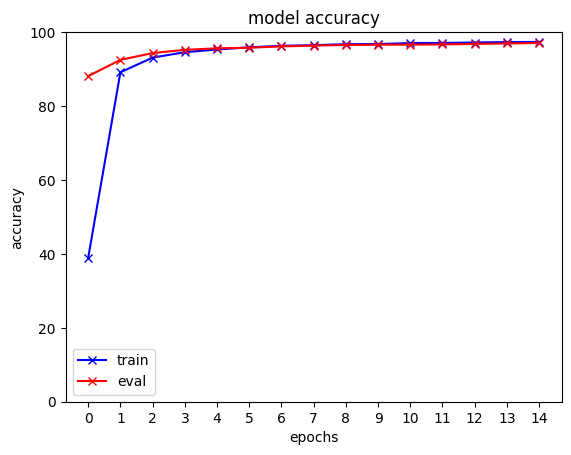

In [17]:
epochs = 15
learningRate = 0.01
modelInfo = train(myModel, learningRate, epochs, train_ld, val_ld)
plot_acc(modelInfo)

In [18]:
test(myModel, test_ld)

test phase:
average loss is:0.0004 , and percentage of correct prediction:98.32%


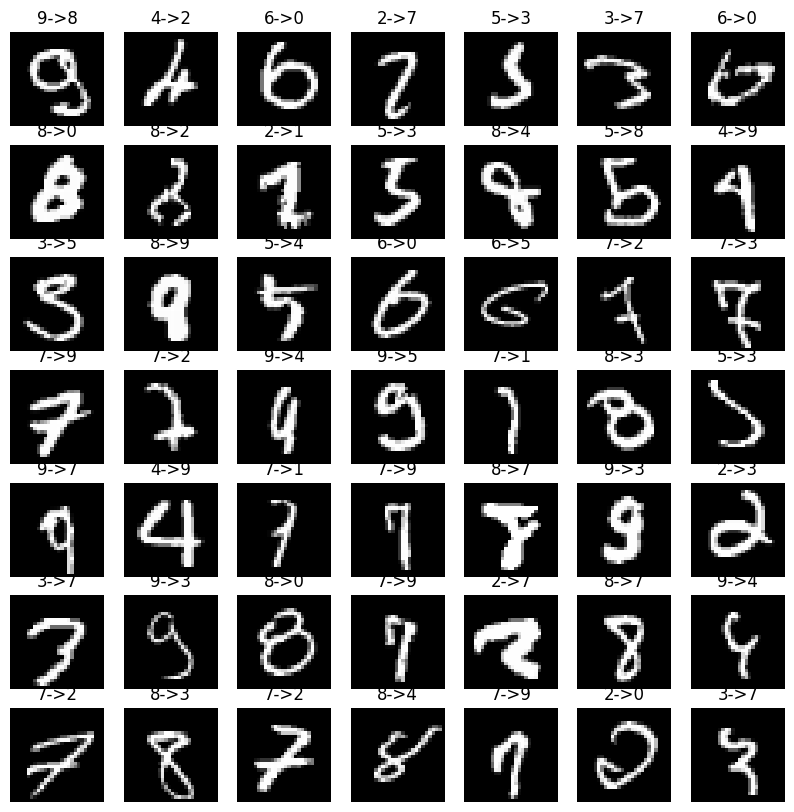

In [34]:
#ploting mistakes prediction in test data

fig = plt.figure(figsize=(10,10))
counter = 0
for img,lbl in test_ld:
  pred = myModel(img)
  pred = torch.argmax(pred, dim=1)
  plt.axis('off')
  for i in range(img.shape[0]):
    if lbl[i].item() != pred[i].item():

      fig.add_subplot(7,7,counter+1)
      plt.imshow(torch.Tensor.cpu(img[i][0,:,:]),'gray')
      plt.axis('off')
      title = str(lbl[i].item()) +'->'+ str(pred[i].item())
      plt.title(title)
      counter += 1
    if counter>48:
      break
  if counter>48:
      break